# Punto 1 y 2 desafio

## Import

In [32]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from skimage.segmentation import quickshift
import pandas as pd
from scipy import stats
import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb

import os

os.environ["USE_PYGEOS"] = "0"
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

from dea_tools.plotting import display_map, rgb


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42489 instead
  warnings.warn(


In [33]:
#!pip show dask

In [34]:
dc = datacube.Datacube(app='final')

## imput usuario datos

In [35]:
buffer = .1

petorca_coordinates = {
    "y": (-32.08, -32.35),
    "x": (-70.6, -71.09)
}

# Set the central latitude and longitude
central_lat = -32.2517
central_lon = -70.9233

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat + buffer, central_lat - buffer)
study_area_lon = (central_lon + buffer*1, central_lon - buffer*1)



## Create query and load data

In [36]:
query = {
    "product": "fasat_charlie_ms",
    # "measurements" : ["red", "nir08", "qa_pixel"],
    "y": study_area_lat, 
    "x": study_area_lon,
    "time": ("2012-01-01", "2024-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [37]:
query_2 = {
    "product": "landsat8_c2l2_sr",
    "y": study_area_lat, 
    "x": study_area_lon,
    "time": ("2014-01-01", "2022-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [38]:
# Load available data
ds = dc.load(**query)
ds_2 = dc.load(**query_2)

## Clean data

In [39]:
quality_band = 'qa_pixel'
cloud_free_mask = (
    masking.make_mask(ds_2[quality_band], snow='high_confidence') + 
    masking.make_mask(ds_2[quality_band], cloud="high_confidence") +
    masking.make_mask(ds_2[quality_band], cirrus="high_confidence") +
    masking.make_mask(ds_2[quality_band], cloud_shadow="high_confidence") +
    masking.make_mask(ds_2[quality_band], nodata=True)
)

In [40]:
dsf = xr.where(cloud_free_mask, np.nan, ds_2)
dsf.update(dsf * 0.0000275 + -0.2)

<xarray.Dataset>
Dimensions:      (time: 398, y: 751, x: 642)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-09T14:34:32.876482 ... 2022-12...
  * y            (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x            (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    nir08        (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    qa_pixel     (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    qa_aerosol   (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    qa_radsat    (time, y, x) float64 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>

## calculo de nvdi

In [41]:
# Para punto 2, Landsat
ndvi_2 = (dsf['nir08'] - dsf['red']) / (dsf['nir08'] + dsf['red'])

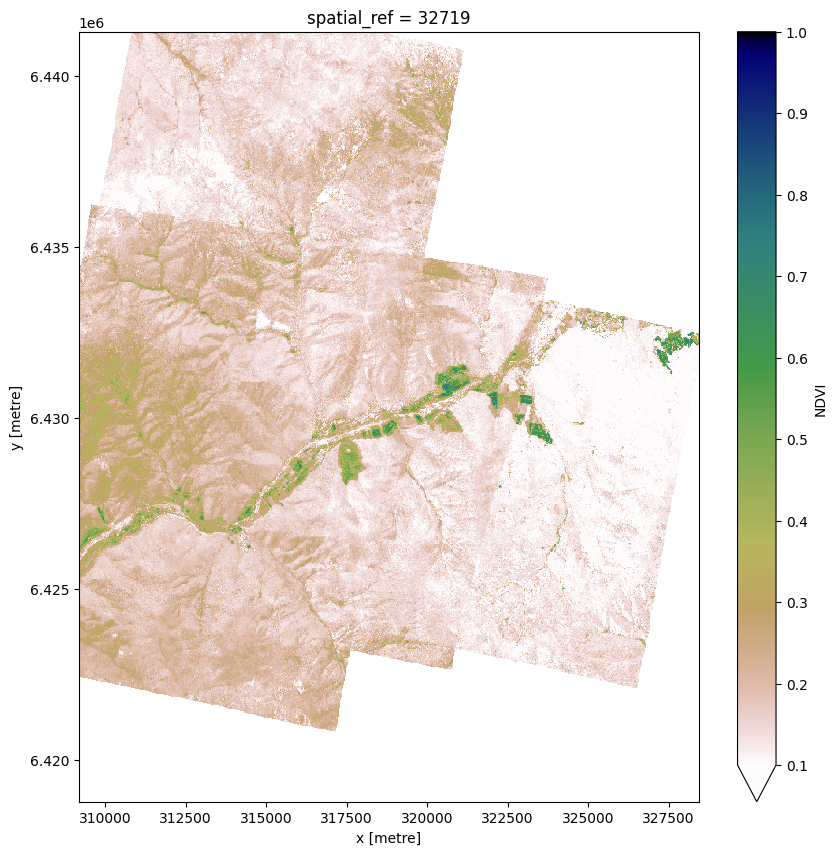

In [55]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', collection='ga_s2_3')

# For each pixel, calculate the mean NDVI throughout the whole timeseries
ndvi = ndvi.mean(dim='time', keep_attrs=False)

# Plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=1.0, cmap='gist_earth_r', figsize=(10, 10))

## distance and km2

In [43]:
from geopy.distance import distance

buffer = .1

petorca_coordinates = {
    "y": (-32.08, -32.35),
    "x": (-70.6, -71.09)
}

coords_1_x = (central_lat + buffer, central_lon + buffer*1) 
coords_2_x = (central_lat - buffer, central_lon + buffer*1)
coords_1_y = (central_lat + buffer, central_lon + buffer*1)  
coords_2_y = (central_lat + buffer, central_lon - buffer*1)

# Calculate distance using geopy.distance.distance
distance_x = distance(coords_1_x, coords_2_x)
distance_y = distance(coords_1_y, coords_2_y)

sqkm = distance_y.km*distance_x.km

print(f"Distance in x: {distance_x.km:.2f} km")
print(f"Distance in y: {distance_y.km:.2f} km")
print(f"Distance in km2: {distance_y.km*distance_x.km:.2f} km2")

Distance in x: 22.18 km
Distance in y: 18.87 km
Distance in km2: 418.45 km2


In [44]:
# calculate % of image over a threshold of ndvi
input_array = ndvi.NDVI.values


/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [45]:
threshold = 0.7

count_over_threshold = np.count_nonzero(input_array > threshold)
print(count_over_threshold)
print(len(input_array)*len(input_array[0]))

# Calculate percentage
percentage_over_threshold = (count_over_threshold / (len(input_array)*len(input_array[0]))) * 100

# Print the result
print(f"Percentage of values over {threshold}: {percentage_over_threshold:.2f}%")

119
482142
Percentage of values over 0.7: 0.02%


## Estimacion consumo de agua en base a ET

In [46]:
ndvi = np.where(np.isnan(input_array), -1,input_array)

# Sample area in square kilometers (replace with your actual area)
area_km2 = sqkm

# Reference ET values
# This is a simplified example, in practice ET coefficients should be based on weather data
# source: https://www.fao.org/3/X0490E/x0490e04.htm#reference%20crop%20evapotranspiration%20(eto)
et_coeff = {
    0.3: 2,# Low NDVI (bare soil)
    0.4: 2,# Low NDVI (bare soil)
    0.5: 3,# Medium NDVI (grassland)
    0.6: 3,# Medium NDVI (grassland)
    0.7: 6,# High NDVI (dense vegetation)
    0.8: 6,# High NDVI (dense vegetation)
    0.9: 6,# High NDVI (dense vegetation)
}

# Calculate reference ET based on NDVI classes
et_ref = np.vectorize(lambda x: et_coeff.get(int(x*10)/10, 0))(ndvi)

# Calculate total water use (assuming constant ET rate over the area)
total_water_use = np.sum(et_ref) * area_km2

# Print the results (modify to suit your needs)
print("Estimated total water use:", total_water_use, "cubic meters (assuming constant ET rate)")

Estimated total water use: 14483698.427770535 cubic meters (assuming constant ET rate)


## estimacion perdida promedio de NVDI 

In [47]:
t0_date = np.datetime64('2014-12-31')
t1_date = np.datetime64('2022-12-31')
t0 = ndvi_2.time.dt.year == t0_date.astype(object).year
t1 = ndvi_2.time.dt.year == t1_date.astype(object).year

t0_sample = ndvi_2.sel(time = t0)
t1_sample = ndvi_2.sel(time = t1)

sample_lat_coords = ndvi_2.coords['y']
sample_lon_coords = ndvi_2.coords['x']

In [48]:
tstat, p_tstat = stats.ttest_ind(
    t1_sample.values,
    t0_sample.values,
    equal_var=False,
    nan_policy='omit',
)

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [49]:
# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {
        't_stat': (['y', 'x'], tstat),
        'p_val': (['y', 'x'], p_tstat)
    },
    coords={
        'x': (['x'], sample_lon_coords.values),
        'y': (['y'], sample_lat_coords.values)
    }, 
    attrs={
        'crs': 'EPSG:32719',
    })

t_test

<xarray.Dataset>
Dimensions:  (y: 751, x: 642)
Coordinates:
  * x        (x) float64 3.092e+05 3.092e+05 3.093e+05 ... 3.284e+05 3.284e+05
  * y        (y) float64 6.441e+06 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
Data variables:
    t_stat   (y, x) float64 0.2452 0.1915 0.6568 ... -0.1918 -0.3506 -0.1966
    p_val    (y, x) float64 0.8078 0.8491 0.5136 0.9886 ... 0.8496 0.7292 0.8461
Attributes:
    crs:      EPSG:32719

In [50]:
sig_level = 0.05
data = t1_sample.mean(dim=['time']).where(t_test.p_val < sig_level) / t0_sample.mean(dim=['time']).where(t_test.p_val < sig_level)-1
arr = data.values
replaced_arr = np.where(arr > 0, np.nan, arr)
# Calculate the mean of the flattened array (ignoring NaN values)
mean_value = np.nanmean(replaced_arr, axis = None)

In [51]:
mean_value

-0.28444060372791885

In [52]:
threshold = 0

# Calculate percentage
percentage_over_threshold = (1-(np.isnan(arr).sum() / (len(replaced_arr)*len(replaced_arr[0]))))*100

# Print the result
print(f"Ha disminuido el indice significativamente de NDVI en: {percentage_over_threshold:.2f}% de la zona")

Ha disminuido el indice significativamente de NDVI en: 10.13% de la zona


## Output para usuario

In [57]:

# Area estudiada
print(f"Distance in x: {distance_x.km:.2f} km")
print(f"Distance in y: {distance_y.km:.2f} km")
print(f"Squared km: {distance_y.km*distance_x.km:.2f} km2")

Distance in x: 22.18 km
Distance in y: 18.87 km
Squared km: 418.45 km2


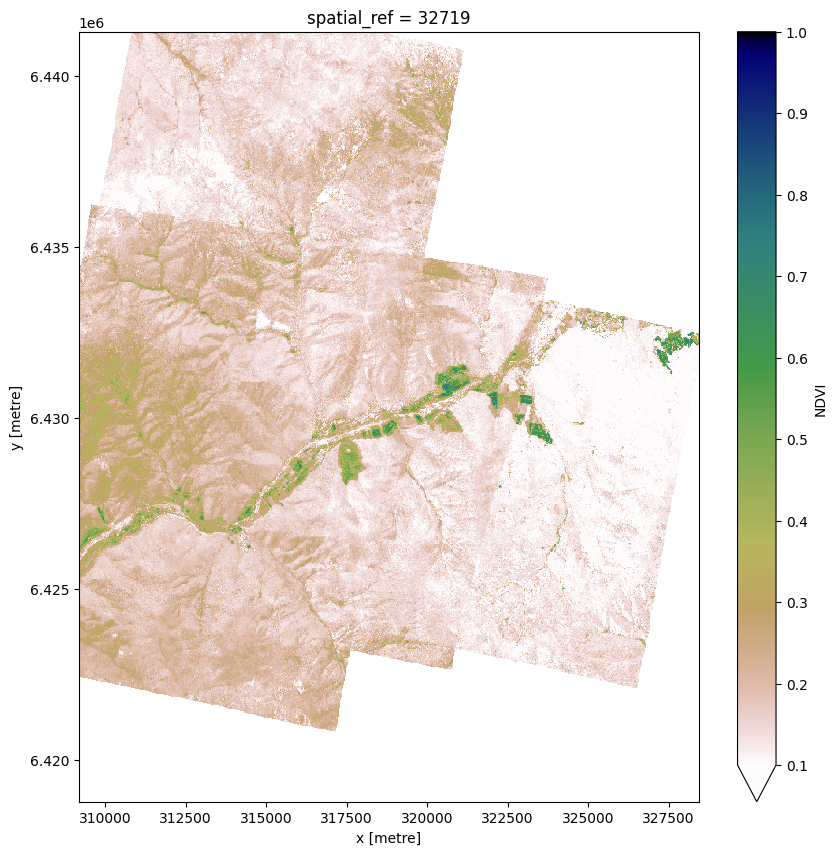

In [58]:
# Plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=1.0, cmap='gist_earth_r', figsize=(10, 10))

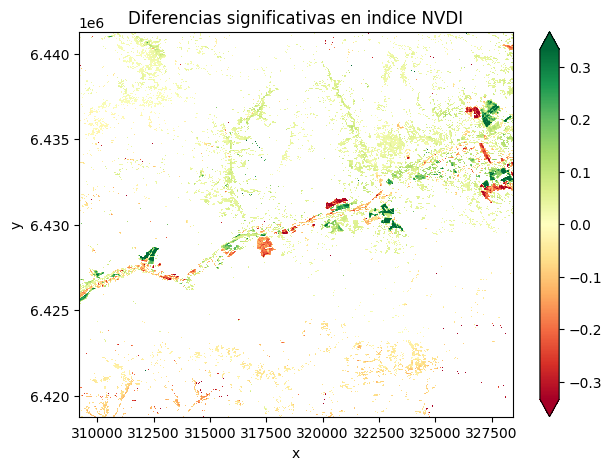

In [59]:
# Set the significance level
sig_level = 0.05

# Plot any difference in the mean classified as significant
sig_diff_mean = t1_sample.mean(dim=['time']).where(t_test.p_val < sig_level) - t0_sample.mean(dim=['time']).where(t_test.p_val < sig_level)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sig_diff_mean.plot(cmap='RdYlGn', robust=True)
ax.set_title('Diferencias significativas en indice NVDI')
ax.set_facecolor("white")
plt.show()

In [60]:
print("Estimated total water use:", str(int(total_water_use)), "cubic meters (assuming constant ET rate)")

Estimated total water use: 14483698 cubic meters (assuming constant ET rate)


In [61]:
print("En promedio se ha disminuido el indice de NVDI en", str(int(-1*mean_value*100)), "% en el tiempo")
print("En las zonas donde hay una deforestacion significativa")

En promedio se ha disminuido el indice de NVDI en 28 % en el tiempo
En las zonas donde hay una deforestacion significativa


In [62]:
print(f"Ha disminuido el indice significativamente de NDVI en: {percentage_over_threshold:.2f}% de la zona")

Ha disminuido el indice significativamente de NDVI en: 10.13% de la zona


In [63]:
red_total = int(-1*mean_value * total_water_use * percentage_over_threshold/100  )

print("El impacto de la sequia en las zonas con disminucion significativa corresponde a un equivalente de ")
print( red_total, "metros cubicos de agua")

El impacto de la sequia en las zonas con disminucion significativa corresponde a un equivalente de 
417194 metros cubicos de agua
